# Machine Learning

In [ ]:
import os # version: 3.9.19
import sys # version: 3.9.19
import pandas as pd # version: 2.2.2
import qiime2 as q2 # version: 2024.5.0
from qiime2 import Visualization
import matplotlib.pyplot as plt # version: 3.8.4
%matplotlib inline

# Define the data directory
data_dir = './data'

In [ ]:
import os

In [48]:
!pwd

/home/jovyan/FunGut2/full-pipeline


In [55]:
!qiime sample-classifier classify-samples --help

Usage: qiime sample-classifier classify-samples [OPTIONS]

  Predicts a categorical sample metadata column using a supervised learning
  classifier. Splits input data into training and test sets. The training set
  is used to train and test the estimator using a stratified k-fold cross-
  validation scheme. This includes optional steps for automated feature
  extraction and hyperparameter optimization. The test set validates
  classification accuracy of the optimized estimator. Outputs classification
  results for test set. For more details on the learning algorithm, see
  http://scikit-learn.org/stable/supervised_learning.html

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency | RelativeFrequency |
    PresenceAbsence | Composition]
                          Feature table containing all features that should
                          be used for target prediction.            [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Categorical]


### Qiime2 classifier function

In [49]:
! rm -r ./data/machine_learning

In [52]:
!qiime sample-classifier classify-samples \
    --i-table $data_dir/feature_tables_dada/filtered-feature-table.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --m-metadata-column age_group \
    --p-random-state 42 \
    --p-parameter-tuning \
    --p-estimator RandomForestClassifier \
    --output-dir ./data/machine_learning

Saved SampleEstimator[Classifier] to: ./data/machine_learning/sample_estimator.qza
Saved FeatureData[Importance] to: ./data/machine_learning/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: ./data/machine_learning/predictions.qza
Saved Visualization to: ./data/machine_learning/model_summary.qzv
Saved Visualization to: ./data/machine_learning/accuracy_results.qzv
Saved SampleData[Probabilities] to: ./data/machine_learning/probabilities.qza
Saved Visualization to: ./data/machine_learning/heatmap.qzv
Saved SampleData[TrueTargets] to: ./data/machine_learning/training_targets.qza
Saved SampleData[TrueTargets] to: ./data/machine_learning/test_targets.qza


In [54]:
Visualization.load('./data/machine_learning/accuracy_results.qzv')

<visualization: Visualization uuid: 2e63e401-21f2-4add-ad54-2b0dc2b2a899>

# Self made Classifier

In [ ]:
!pip install imblearn

In [ ]:
!pip install xgboost

In [ ]:
!pip show seaborn

In [ ]:
!pip install --upgrade seaborn

In [4]:
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
%matplotlib inline

from biom import load_table
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import SparsePCA

# Define the data directory
data_dir = './data'

### export feature table and load as data frame

In [ ]:
!qiime tools export \
        --input-path $data_dir/feature_tables_dada/filtered-feature-table.qza \
        --output-path $data_dir/feature_tables_dada/exported-feature-table

In [5]:
# Load the .biom file
biom_table = load_table(f'{data_dir}/feature_tables_dada/exported-feature-table/feature-table.biom')

# Convert the biom table to a pandas DataFrame
feature_table = biom_table.to_dataframe()

In [6]:
meta = pd.read_csv(f'{data_dir}/metadata/fungut_metadata_processed.tsv', sep='\t')

### Prepare data (X=features and y=label)

In [166]:
X = feature_table.T  
y = meta.gluten_symptoms 

#filter 'not_provided'
y = y[y != 'Not provided']
X = X.iloc[y.index]

In [167]:
# scale with log-transformation
X = np.log1p(X) 
# turn into numpy array
X = X.to_numpy()
y = y.to_numpy()

In [168]:
#spca = SparsePCA(n_components=100, random_state=42)
#X = spca.fit_transform(X)

# Encode the target labels
le = LabelEncoder()
y = le.fit_transform(y)  # Converts strings to integers

### Model computation

Accuracy: 0.6551724137931034
Ratio (predict most likely): 0.826086956521739
True class distribution: {0: 23, 1: 6}
Predicted class distribution: {0: 21, 1: 8}
[[17  6]
 [ 4  2]]


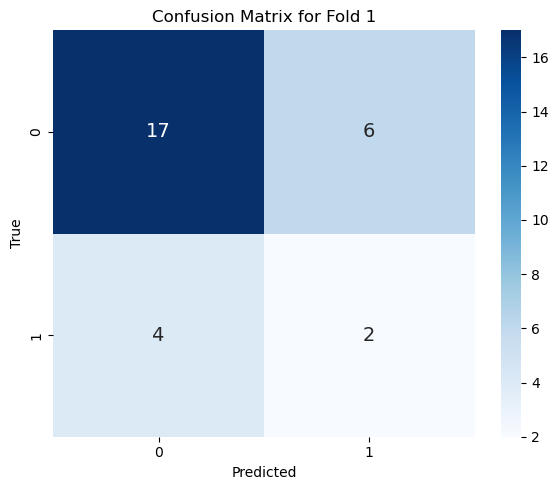

Accuracy: 0.5517241379310345
Ratio (predict most likely): 0.6956521739130435
True class distribution: {0: 23, 1: 6}
Predicted class distribution: {0: 18, 1: 11}
[[14  9]
 [ 4  2]]


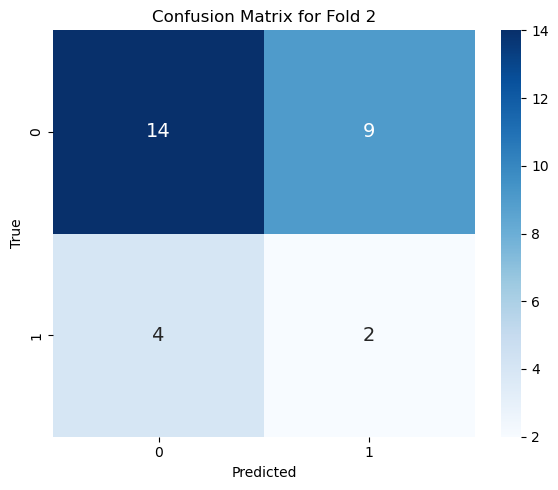

Accuracy: 0.6206896551724138
Ratio (predict most likely): 0.782608695652174
True class distribution: {0: 23, 1: 6}
Predicted class distribution: {0: 24, 1: 5}
[[18  5]
 [ 6  0]]


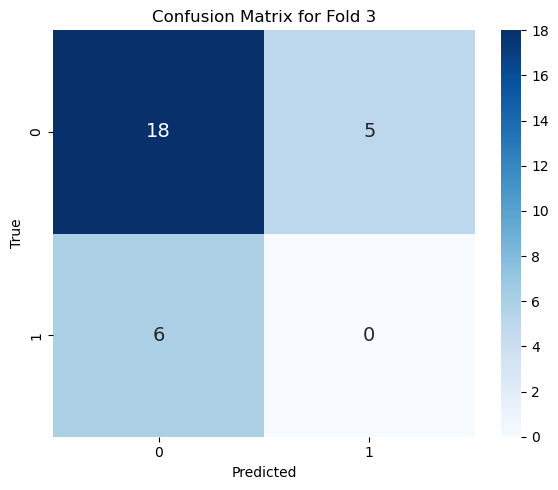

Accuracy: 0.7241379310344828
Ratio (predict most likely): 0.9545454545454546
True class distribution: {0: 22, 1: 7}
Predicted class distribution: {0: 26, 1: 3}
[[20  2]
 [ 6  1]]


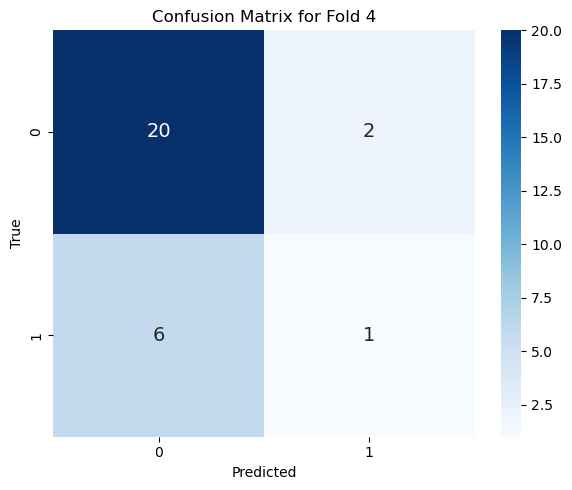

Accuracy: 0.7142857142857143
Ratio (predict most likely): 0.9090909090909092
True class distribution: {0: 22, 1: 6}
Predicted class distribution: {0: 24, 1: 4}
[[19  3]
 [ 5  1]]


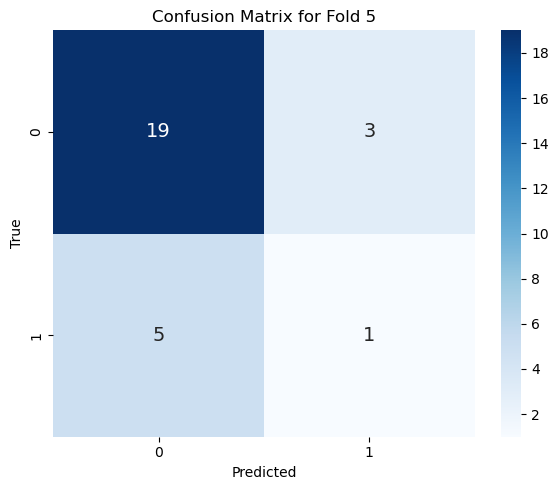

In [169]:
# Stratified K-Fold Cross-validation (ensures each fold has the same class distribution)
kf = StratifiedKFold(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    #calculate scale to adjust weight of underreprestend group
    scale_pos_weight =  (len(y_train) - sum(y_train)) / sum(y_train)
    
    # Apply SMOTE to the training set --> create new datapoints of minority group (disease)
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    #model = RandomForestClassifier(class_weight='balanced', random_state=42)
    #model.fit(X_train, y_train)

    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,  
                              eval_metric='logloss',
                              objective='binary:logistic')
    model.fit(X_train_smote, y_train_smote)

    #model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)
    #model.fit(X_train_smote, y_train_smote)
    
    
    
    # Evaluate model
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Ratio (predict most likely): {accuracy_score(y_test, y_pred)/((len(y_test) - sum(y_test))/len(y_test))}')
    
    # Get class distribution using numpy.unique()
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    # Print class distributions
    print(f"True class distribution: {dict(zip(unique_test, counts_test))}")
    print(f"Predicted class distribution: {dict(zip(unique_pred, counts_pred))}")
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y),
               annot_kws={"size": 14})  # Increase font size for annotations
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

### Try to predict country (USA, UK and Australia)

In [162]:
X = feature_table.T  
y = meta.country_sample

#filter 'not_provided'
y = y[y.isin(['United Kingdom', 'USA', 'Australia'])]
X = X.iloc[y.index]
# scale with log-transformation
X = np.log1p(X) 
# turn into numpy array
X = X.to_numpy()
y = y.to_numpy()
le = LabelEncoder()
y= le.fit_transform(y)  # Converts strings to integers

In [163]:
print(y)

counts = np.bincount(y)
most_common_count = counts.max()
accuracy_null_model = most_common_count / len(y)
print('Accuracy of predicting overrepresented =', accuracy_null_model)

[1 1 1 2 2 2 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Accuracy of predicting overrepresented = 0.381294964028777


Accuracy: 0.35714285714285715
Ratio (predict most likely): 0.9366576819407008
True class distribution: {0: 8, 1: 9, 2: 11}
Predicted class distribution: {0: 8, 1: 8, 2: 12}
[[2 5 1]
 [4 1 4]
 [2 2 7]]


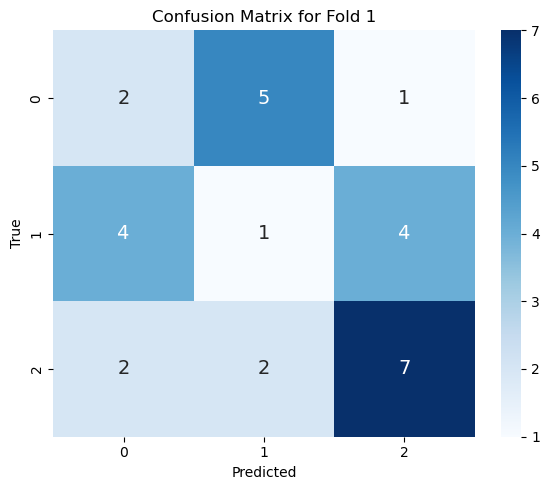

Accuracy: 0.42857142857142855
Ratio (predict most likely): 1.123989218328841
True class distribution: {0: 8, 1: 9, 2: 11}
Predicted class distribution: {0: 5, 1: 8, 2: 15}
[[3 3 2]
 [1 2 6]
 [1 3 7]]


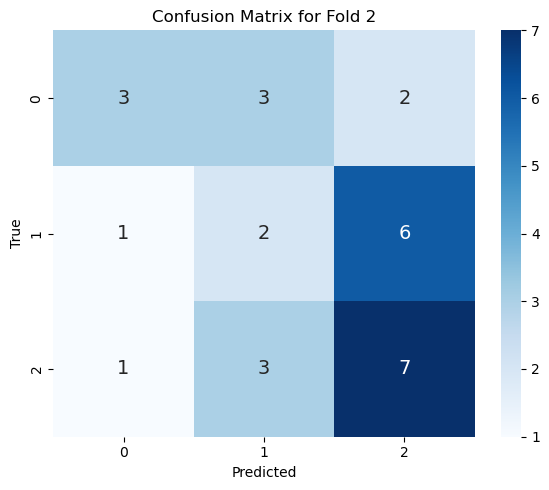

Accuracy: 0.5357142857142857
Ratio (predict most likely): 1.4049865229110512
True class distribution: {0: 9, 1: 9, 2: 10}
Predicted class distribution: {0: 5, 1: 10, 2: 13}
[[3 3 3]
 [1 5 3]
 [1 2 7]]


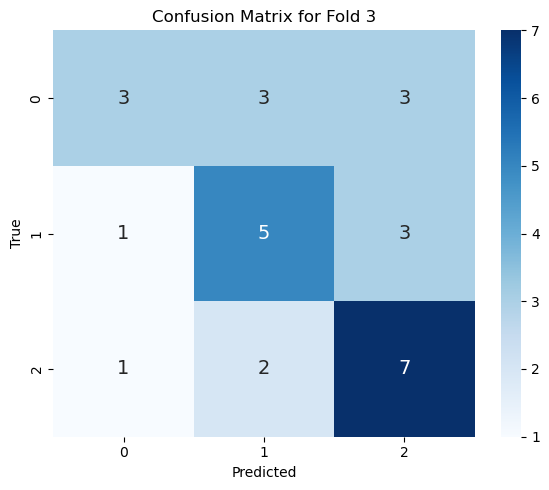

Accuracy: 0.42857142857142855
Ratio (predict most likely): 1.123989218328841
True class distribution: {0: 9, 1: 9, 2: 10}
Predicted class distribution: {0: 7, 1: 6, 2: 15}
[[3 0 6]
 [3 3 3]
 [1 3 6]]


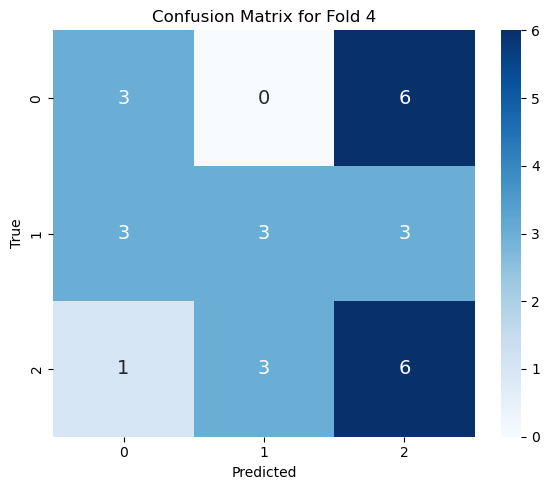

Accuracy: 0.48148148148148145
Ratio (predict most likely): 1.2627533193570928
True class distribution: {0: 8, 1: 8, 2: 11}
Predicted class distribution: {0: 8, 1: 9, 2: 10}
[[3 3 2]
 [4 3 1]
 [1 3 7]]


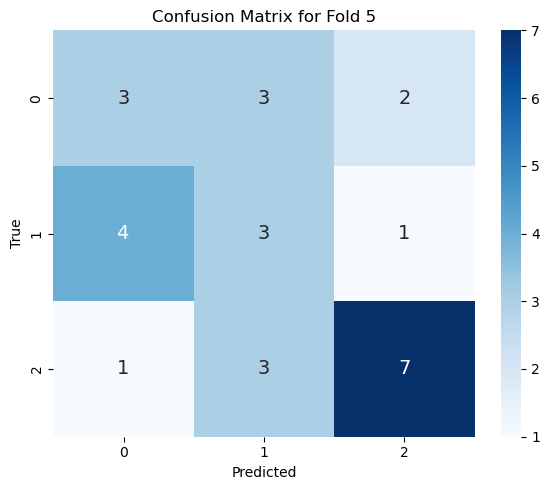

In [164]:
# Stratified K-Fold Cross-validation (ensures each fold has the same class distribution)
kf = StratifiedKFold(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = xgb.XGBClassifier(eval_metric='mlogloss',
                              objective = 'multi:softmax')
    model.fit(X_train, y_train)
    
    
    
    # Evaluate model
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Ratio (predict most likely): {accuracy_score(y_test, y_pred)/accuracy_null_model}')
    
    # Get class distribution using numpy.unique()
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    # Print class distributions
    print(f"True class distribution: {dict(zip(unique_test, counts_test))}")
    print(f"Predicted class distribution: {dict(zip(unique_pred, counts_pred))}")
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y),
               annot_kws={"size": 14})  # Increase font size for annotations
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()